In [1]:
import numpy as np
import pandas as pd
import akshare as ak
import statsmodels.formula.api as smf
import os

# ==========================================
# 1. 基金数据准备
# ==========================================
fund_code = "001938"
start_date = "20190101"
fund_individual_basic_info_xq_df = ak.fund_individual_basic_info_xq(symbol=fund_code)
fund_net_value_df = ak.fund_open_fund_info_em(
    symbol=fund_code,
    indicator="累计净值走势",
    )
fund_net_value_df["净值日期"] = pd.to_datetime(fund_net_value_df["净值日期"])
fund_df = fund_net_value_df[fund_net_value_df["净值日期"] >= start_date]
fund_df = fund_df.set_index("净值日期", drop=True)
fund_df['日度回报率'] = fund_df['累计净值'].pct_change()
fund_df.dropna(subset=['日度回报率'], inplace=True)
# ==========================================
# 2. 因子数据准备，读取参考文件
# ==========================================
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "CAPM单因子模型（经典算法）日收益率（截至到20250630）.csv")

factor_capm = pd.read_csv(target_file_path)
factor_capm['date'] = pd.to_datetime(factor_capm['date'])
factor_capm.set_index('date', inplace=True)
# ==========================================
# 3. 数据合并与预处理
# ==========================================
capm_data = pd.merge(fund_df[['日度回报率']], factor_capm, left_index=True, right_index=True, how='inner')
capm_data['Ri_Rf'] = capm_data['日度回报率'] - capm_data['RF']
capm_data['Market'] = capm_data['MKT'] - capm_data['RF']
# ==========================================
# 4. CAPM回归分析
# ==========================================
formula = 'Ri_Rf ~ Market'
model = smf.ols(formula=formula, data=capm_data).fit()
alpha_daily = model.params['Intercept']
alpha_annualized = alpha_daily * 250
print(model.summary())
print(f"基金 {fund_code} 年化超额收益为{alpha_annualized:.2%}")
print(fund_df)


                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     3662.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:05:51   Log-Likelihood:                 6124.7
No. Observations:                1572   AIC:                        -1.225e+04
Df Residuals:                    1570   BIC:                        -1.223e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.906      0.3

In [2]:
# ==========================================
# 5. 择时能力分析
# ==========================================
capm_data['Market_sq'] = capm_data['Market'] ** 2
formula = 'Ri_Rf ~ Market + Market_sq'
model = smf.ols(formula=formula, data=capm_data).fit()
alpha_daily = model.params['Intercept']
alpha_annualized = alpha_daily * 250
print(model.summary())
print(f"基金 {fund_code} 年化超额收益为{alpha_annualized:.2%}")

                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1837.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:05:51   Log-Likelihood:                 6126.9
No. Observations:                1572   AIC:                        -1.225e+04
Df Residuals:                    1569   BIC:                        -1.223e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      1.516      0.1

In [3]:
# ==========================================
# 1. # Carhart四因子数据准备，读取参考文件
# ==========================================
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "Carhart-四因子模型（经典算法）日收益率（截至到20250630）.csv")

factor_car = pd.read_csv(target_file_path)
factor_car['date'] = pd.to_datetime(factor_car['date'])
factor_car.set_index('date', inplace=True)
# ==========================================
# 2. 数据合并与预处理
# ==========================================
car_data = pd.merge(fund_df[['日度回报率']], factor_car, left_index=True, right_index=True, how='inner')
car_data['Ri_Rf'] = car_data['日度回报率'] - car_data['RF']
car_data['Market'] = car_data['MKT'] - car_data['RF']
# ==========================================
# 3. Carhart四因子回归分析
# ==========================================
formula = 'Ri_Rf ~ Market + SMB + HML + UMD'
model = smf.ols(formula=formula, data=car_data).fit()
alpha_daily = model.params['Intercept']
alpha_annualized = alpha_daily * 250
p_value = model.pvalues['Intercept']
print(model.summary())
print(f"基金 {fund_code} 年化超额收益为{alpha_annualized:.2%}")


                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1606.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:05:51   Log-Likelihood:                 6458.9
No. Observations:                1572   AIC:                        -1.291e+04
Df Residuals:                    1567   BIC:                        -1.288e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      1.456      0.1

In [4]:
# ==========================================
# 1. # 模型因子拓展：读取DHS因子数据
# ==========================================
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "Daniel-Hirshleifer-Sun-三因子模型（经典算法）日收益率（截至到20250630）.csv")

factor_dhs = pd.read_csv(target_file_path)
factor_dhs['date'] = pd.to_datetime(factor_dhs['date'])
factor_dhs.set_index('date', inplace=True)
# ==========================================
# 2. 数据合并
# ==========================================
full_data=pd.merge(car_data,factor_dhs[['R_fin','R_pead']],left_index=True,right_index=True)
full_data.dropna(inplace=True)
# ==========================================
# 3. 运行合并“六因子”回归分析
# ==========================================
formula = 'Ri_Rf ~ Market + SMB + HML + UMD + R_pead + R_fin'
model = smf.ols(formula=formula, data=full_data).fit()
alpha_daily = model.params['Intercept']
alpha_annualized = alpha_daily * 250
print(model.summary())
print(f"基金 {fund_code} 年化超额收益为{alpha_annualized:.2%}")

                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1100.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:05:51   Log-Likelihood:                 6476.7
No. Observations:                1572   AIC:                        -1.294e+04
Df Residuals:                    1565   BIC:                        -1.290e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002   9.99e-05      1.900      0.0

In [5]:
# ==========================================
# 4. 多重共线性检查：VIF
# ==========================================
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X_factors = full_data[['Market', 'SMB', 'HML', 'UMD', 'R_fin', 'R_pead']]
X_factors_with_const = add_constant(X_factors)
def get_vif_summary(X_data):
    vif_data = pd.DataFrame()
    vif_data["Factor"] = X_data.columns
    vif_data["VIF"] = [variance_inflation_factor(X_data.values, i) 
                       for i in range(X_data.shape[1])]
    vif_data = vif_data[vif_data['Factor'] != 'const']
    vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)
    return vif_data
vif_summary = get_vif_summary(X_factors_with_const)
print(vif_summary)

   Factor       VIF
0   R_fin  3.538052
1     HML  2.185151
2     SMB  1.956189
3  Market  1.290608
4     UMD  1.110312
5  R_pead  1.051390


In [6]:
# ==========================================
# 5. 择时能力分析
# ==========================================
car_data['Market_sq'] = car_data['Market'] ** 2
formula = 'Ri_Rf ~ Market + Market_sq + SMB + HML + UMD'
model =smf.ols(formula, car_data).fit()
alpha_daily = model.params['Intercept']
alpha_annualized = alpha_daily * 250
print(model.summary())
print(f"基金 {fund_code} 年化超额收益为{alpha_annualized:.2%}")

                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1297.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:05:51   Log-Likelihood:                 6465.4
No. Observations:                1572   AIC:                        -1.292e+04
Df Residuals:                    1566   BIC:                        -1.289e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      2.511      0.0

>>> 开始执行滚动回归 (全样本)
区间: 2019-01-01 - 至今
窗口: 252 天


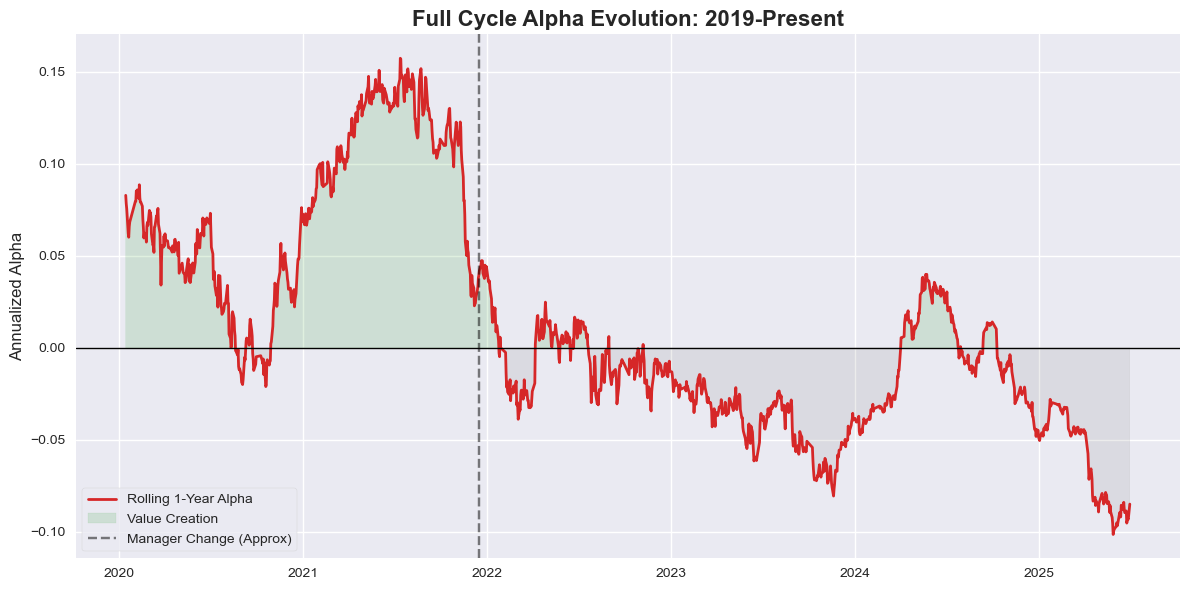

In [7]:
# =============================================================================
# Pre后补充分析
# 一.滚动窗口Alpha分析
# =============================================================================

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# ==========================================
# 1. 参数设置
# ==========================================
# 【关键调整】从 2019 年开始 (包含前任和现任经理的全周期)
analysis_start_date = "2019-01-01"

# 【建议】时间长了，窗口建议用 252天 (1年)，看长期能力
# 如果您想保持和之前一样的灵敏度，也可以改成 126
window_size = 252 

# 准备数据：确保包含 2019 年以来的数据
rolling_data = car_data[car_data.index >= pd.to_datetime(analysis_start_date)].copy()
rolling_data = rolling_data.sort_index()

rolling_dates = []
rolling_alphas = []

# 定义模型 (Carhart 四因子)
# 确保您的 car_data 里有这些列
X = rolling_data[['Market', 'SMB', 'HML', 'UMD']]
X = sm.add_constant(X)
y = rolling_data['Ri_Rf']

print(f">>> 开始执行滚动回归 (全样本)")
print(f"区间: {analysis_start_date} - 至今")
print(f"窗口: {window_size} 天")

# ==========================================
# 2. 滚动计算 Alpha
# ==========================================
for i in range(window_size, len(rolling_data)):
    # 切片
    y_window = y.iloc[i-window_size : i]
    X_window = X.iloc[i-window_size : i]
    current_date = rolling_data.index[i]
    
    try:
        model = sm.OLS(y_window, X_window).fit()
        # 提取年化 Alpha
        alpha_annual = model.params['const'] * 250
        rolling_dates.append(current_date)
        rolling_alphas.append(alpha_annual)
    except:
        pass

# 结果转为 DataFrame
df_rolling = pd.DataFrame({'Date': rolling_dates, 'Alpha': rolling_alphas}).set_index('Date')

# ==========================================
# 3. 绘图 (全周期视角)
# ==========================================
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制 Alpha 曲线
ax.plot(df_rolling.index, df_rolling['Alpha'], color='#d62728', linewidth=2, label='Rolling 1-Year Alpha')

# 填充颜色 (区分正负)
ax.fill_between(df_rolling.index, df_rolling['Alpha'], 0, 
                where=(df_rolling['Alpha'] >= 0), color='#2ca02c', alpha=0.15, label='Value Creation')
ax.fill_between(df_rolling.index, df_rolling['Alpha'], 0, 
                where=(df_rolling['Alpha'] < 0), color='gray', alpha=0.15)

# 添加关键时间分割线 (比如经理变更大概在 2021年底)
# 您可以根据实际情况调整这个日期，或者不加
ax.axvline(pd.to_datetime("2021-12-17"), color='black', linestyle='--', alpha=0.5, label='Manager Change (Approx)')

# 装饰图表
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_title('Full Cycle Alpha Evolution: 2019-Present', fontsize=16, fontweight='bold')
ax.set_ylabel('Annualized Alpha', fontsize=12)
ax.legend(loc='lower left', frameon=True)

plt.tight_layout()
plt.show()

## **对Alpha滚动回归的分析**
该基金的 Alpha 曲线（绿色区域）长期显著位于 0 轴上方。 这证明了基金经理持续的主动管理能力。但是，**必须注意的是，基金的 Alpha值 在2021年获得金牛奖之后出现了断崖式下跌**，这是由于该基金在2021年底发生基金经理更换所致。当我们切换分析窗口至2022年以来时，本基金的Alpha在所有模型中全部变成复值，说明本基金在基金经理更换后，主动管理能力出现了下降。

>>> 开始执行滚动择时分析 (Rolling Gamma Only)
区间: 2019-01-01 - 至今


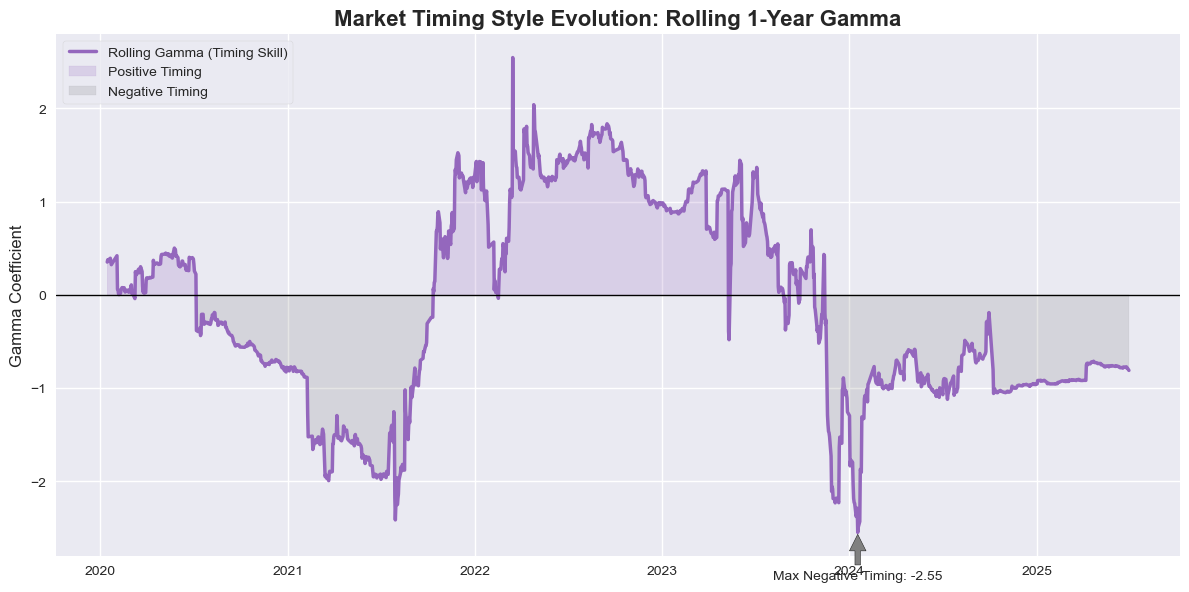

In [8]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# ==========================================
# 1. 参数设置
# ==========================================
# 延续之前的逻辑：从 2019 年开始的全周期
analysis_start_date = "2019-01-01"
window_size = 252  # 1年窗口

# 准备数据
rolling_data = car_data[car_data.index >= pd.to_datetime(analysis_start_date)].copy()
rolling_data = rolling_data.sort_index()

# 【关键】构建择时项
rolling_data['Market_sq'] = rolling_data['Market'] ** 2

rolling_dates = []
rolling_gammas = []

# 定义模型：Carhart 四因子 + 择时项
X = rolling_data[['Market', 'Market_sq', 'SMB', 'HML', 'UMD']]
X = sm.add_constant(X)
y = rolling_data['Ri_Rf']

print(f">>> 开始执行滚动择时分析 (Rolling Gamma Only)")
print(f"区间: {analysis_start_date} - 至今")

# ==========================================
# 2. 滚动回归计算
# ==========================================
for i in range(window_size, len(rolling_data)):
    y_window = y.iloc[i-window_size : i]
    X_window = X.iloc[i-window_size : i]
    current_date = rolling_data.index[i]
    
    try:
        model = sm.OLS(y_window, X_window).fit()
        # 只提取 Gamma 值
        gamma = model.params['Market_sq']
        rolling_dates.append(current_date)
        rolling_gammas.append(gamma)
    except:
        pass

df_timing = pd.DataFrame({'Date': rolling_dates, 'Gamma': rolling_gammas}).set_index('Date')

# ==========================================
# 3. 绘图 (单图展示数值走势)
# ==========================================
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制 Gamma 曲线
ax.plot(df_timing.index, df_timing['Gamma'], color='#9467bd', linewidth=2.5, label='Rolling Gamma (Timing Skill)')

# 填充颜色：Gamma > 0 (做多波动/正向择时) 为紫，< 0 (做空波动/反向择时) 为灰
ax.fill_between(df_timing.index, df_timing['Gamma'], 0, 
                where=(df_timing['Gamma'] >= 0), color='#9467bd', alpha=0.2, label='Positive Timing')
ax.fill_between(df_timing.index, df_timing['Gamma'], 0, 
                where=(df_timing['Gamma'] < 0), color='gray', alpha=0.2, label='Negative Timing')

# 装饰
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_title('Market Timing Style Evolution: Rolling 1-Year Gamma', fontsize=16, fontweight='bold')
ax.set_ylabel('Gamma Coefficient', fontsize=12)
ax.legend(loc='upper left', frameon=True)

# 可选：标注最低点（最大负向择时时刻）
min_date = df_timing['Gamma'].idxmin()
min_val = df_timing['Gamma'].min()
ax.annotate(f'Max Negative Timing: {min_val:.2f}', xy=(min_date, min_val), xytext=(min_date, min_val-0.5),
            arrowprops=dict(facecolor='gray', shrink=0.05), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

## **对择时因子滚动回归的分析**
基金经理的操作划分三个风格不同的阶段，2022年择时能力很强，这应该是由于2022年单边熊市导致，是一种相对谨慎的防御性策略；2023年风格切换明显，不再注重择时，可能是判断市场见底，开始抄底购入成长股；2024年以来风格较为一致，即几乎完全放弃市场择时，专心深耕成长股，他不再试图通过加减仓来规避波动。

说明基金经理现在的策略是：承受短期波动的痛苦（负 Gamma），以换取未来成长股反弹的弹性，适合能够承受板块轮动过、偏好成长股的投资者购入。